# Inversion and Optimisation <a class="tocSkip"></a>

## Lecture 9: Gradient Based Methods - part two  <a class="tocSkip"></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quasi-Newton-Secant-methods" data-toc-modified-id="Quasi-Newton-Secant-methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quasi-Newton Secant methods</a></span><ul class="toc-item"><li><span><a href="#Broyden's-method,-the-good-and-the-bad-(*)" data-toc-modified-id="Broyden's-method,-the-good-and-the-bad-(*)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Broyden's method, the good and the bad (*)</a></span></li><li><span><a href="#Symmetric-Rank-One-Update-(SR1)-(*)" data-toc-modified-id="Symmetric-Rank-One-Update-(SR1)-(*)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Symmetric Rank One Update (SR1) (*)</a></span></li><li><span><a href="#Broyden-Fletcher-Goldfarb-Shanno-(BFGS)-(*)" data-toc-modified-id="Broyden-Fletcher-Goldfarb-Shanno-(BFGS)-(*)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Broyden-Fletcher-Goldfarb-Shanno (BFGS) (*)</a></span></li><li><span><a href="#Limited-Memory-Implementations" data-toc-modified-id="Limited-Memory-Implementations-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Limited Memory Implementations</a></span></li></ul></li><li><span><a href="#Stopping-Criteria" data-toc-modified-id="Stopping-Criteria-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Stopping Criteria</a></span><ul class="toc-item"><li><span><a href="#Absolute-Tolerance-and-Scaling" data-toc-modified-id="Absolute-Tolerance-and-Scaling-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Absolute Tolerance and Scaling</a></span></li><li><span><a href="#Relative-Tolerance" data-toc-modified-id="Relative-Tolerance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Relative Tolerance</a></span></li><li><span><a href="#Stalling-Criteria" data-toc-modified-id="Stalling-Criteria-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Stalling Criteria</a></span></li><li><span><a href="#Stopping-Criteria-for-Optimisation" data-toc-modified-id="Stopping-Criteria-for-Optimisation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Stopping Criteria for Optimisation</a></span></li></ul></li><li><span><a href="#Truncated-Newton-Methods" data-toc-modified-id="Truncated-Newton-Methods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Truncated Newton Methods</a></span><ul class="toc-item"><li><span><a href="#Truncated-Newton-CG-Example" data-toc-modified-id="Truncated-Newton-CG-Example-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Truncated Newton-CG Example</a></span></li></ul></li><li><span><a href="#Computing-and-Testing-the-Gradient:-Taylor-Test" data-toc-modified-id="Computing-and-Testing-the-Gradient:-Taylor-Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Computing and Testing the Gradient: Taylor Test</a></span><ul class="toc-item"><li><span><a href="#Obtaining-Gradient-Information" data-toc-modified-id="Obtaining-Gradient-Information-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Obtaining Gradient Information</a></span></li><li><span><a href="#Taylor-Test" data-toc-modified-id="Taylor-Test-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Taylor Test</a></span></li><li><span><a href="#Polygons,-Perimeter-and-Area" data-toc-modified-id="Polygons,-Perimeter-and-Area-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Polygons, Perimeter and Area</a></span></li></ul></li><li><span><a href="#List-of-Definitions" data-toc-modified-id="List-of-Definitions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>List of Definitions</a></span></li></ul></div>

## Summary <a class="tocSkip"></a>
We will continue on the subject of quasi Newton methods, by discussing multi-dimensional secant methods, which build up an approximation of the Hessian by looking at the difference in subsequently computed first derivatives. A very popular method in optimisation is BFGS, which guarantees that the approximated Hessian is SPD. The limited memory version L-BFGS limits memory use (and computational time) by throwing away some older information, and in some cases actually improves the Hessian approximation when the local Hessian has changed from the initial location. An issue with secant methods is that the scaling of the initial Hessian influences the convergence.
Further in this lecture, we discuss different criteria to decide when to stop the iteration for the various iterative methods that are discussed in this course. This brings us to the concept of truncated Newton methods, which rather than solving the linear system associated with the Newton step exactly, uses an iterative method with a very loose tolerance. This not only saves on computation but remarkably also improves the robustness of the method. Finally, we discuss how to obtain and test the gradient information that is required in Newton and quasi Newton methods.

### Important concepts: <a class="tocSkip"></a>
- quasi-Newton, secant methods: Broyden, BFGS and L-BFGS-B
- different types of stopping criterion: absolute, relative, stalling
- truncated Newton methods
- Taylor test

In [1]:
# needs to be in separate cell!
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

In [3]:
%%html
<style>
a.definition {
    color: blue;
    font-style: italic;
    font-weight: bold;
}
div.optional {
    background-color: #f0f8ff;
    border-color: #e0f0ff;
    border-left: 5px solid #e0f0ff;
    padding: 0.5em;
}
</style>

# Quasi-Newton Secant methods

For one-dimensional problems we have seen that we can avoid computing the Jacobian $F'$ (Hessian $f''$ in optimisation) using the secant method, where we approximate it using the difference of the two last evaluations of $F$:

$$
  F'(x^{(i)}) \approx  \frac{F(x^{(i)}) - F(x^{(i-1)})}{x^{(i)}-x^{(i-1)}}
$$

In multiple dimensions, the problem is that we need to know the derivative of ${\bf F}$ in multiple directions, whereas this approach only gives us information about the derivative in the direction of the last step: ${\bf x}^{(i)}-{\bf x}^{(i-1)}$:

$$
  {\bf F}'({\bf x}^{(i)}) \left[{\bf x}^{(i)}-{\bf x}^{(i-1)}\right] \approx  {\bf F}({\bf x}^{(i)}) - {\bf F}({\bf x}^{(i-1)})
$$

A solution is to retain information about the derivative in other directions from previous iterations, and build up the approximate Jacobian $\underline{\mathbf B}^{(i)}$ iteratively. In each iteration we demand:

$$
  \underline{\mathbf B}^{(i)} \left[{\bf x}^{(i)}-{\bf x}^{(i-1)}\right] = {\bf F}({\bf x}^{(i)}) - {\bf F}({\bf x}^{(i-1)})
$$

These methods typically start from an initial approximation by a scalar multiple of the identity matrix: $\underline{\mathbf B}^{(0)} = \lambda_0\underline{\mathbf I}$. Note that choosing $\underline{\mathbf B} = \underline{\mathbf I}$ in all iterations would lead to the steepest descent method. Unfortunately this choice means that the secant methods, at least initially, suffer from the same scaling problem as Steepest Descent. Although the methods we discuss have self-correcting properties, the scaling of the initial guess will have an influence on the convergence of the approximate Jacobian $\underline{\mathbf B}^{(i)}$. This initial scaling by $\lambda_0$ is often a user-defined parameter.

In the following sections we will briefly explain the most well known <a class="definition" href="#definitions" id="quasiNewtonsecantmethods">quasi-Newton secant methods</a>: Broyden's method, the symmetric rank-one (SR1) method and the Broyden-Fletcher-Goldfarb-Shanno (BFGS) method. The BFGS method is often used in optimisation problems, where, as we have seen, maintaining Symmetric Positive Definiteness of the Hessian $f''$ is important. In root-finding problems where the Jacobian ${\bf F}'$ is not always symmetric Broyden's method is also used. The big advantage of all quasi-Newton methods over full Newton methods, is the fact that no Hessian (optimisation) or Jacobian (root-finding) information needs to be calculated. In addition, as can be read below, the simple way the approximate Hessian is updated, means that we can also construct the inverse of the approximate Hessian, which means that we can avoid having to do a linear solve to establish the new search direction.

<div class="optional">
To simplify the formulas we introduce the following shorthand for the step in ${\bf x}$, and change in ${\bf F}$

\begin{align*}
  {\bf s} &= {\bf x}^{(i)} - {\bf x}^{(i-1)}, \\
  {\bf y} &= {\bf F}({\bf x}^{(i)}) - {\bf F}({\bf x}^{(i-1)}).
\end{align*}

The <a class="definition" href="#definitions" id="secantequation">secant equation</a> then becomes

<a name='secant-equation'></a>
$$
  \underline{\mathbf B}^{(i)} {\bf s}  = {\bf y}
  \label{secant-equation} \tag{secant-equation}
$$
<br/>
</div>

## Broyden's method, the good and the bad (*)

<div class="optional">
It should noted that the secant equation only provides information about $\underline{\mathbf B}^{(i)}$ in one direction (the current step direction ${\bf s}$). Broyden's method is based on the idea that we want to maintain information of $\underline{\mathbf B}$ in all other directions from our previous Hessian approximation $\underline{\mathbf B}^{(i-1)}$. We can do this by decomposing a vector ${\bf v}$ in a component in the direction of ${\bf s}$ and a component orthogonal to it:

$$
  {\bf v} = {\bf v}^s + {\bf v}^\perp = \frac{{{\bf s}}^T {\bf v}}{{{\bf s}}^T {\bf s}} {\bf s} + \left[{\bf v} - \frac{{{\bf s}}^T {\bf v}}{{{\bf s}}^T {\bf s}} {\bf s}\right]
$$
</div>

<div class="optional">
Then if we apply $\underline{\mathbf B}^{(i)}$ with $\underline{\mathbf B}^{(i)}{\bf v}^\perp = \underline{\mathbf B}^{(i-1)}{\bf v}^\perp$
(i.e. we use the approximate Hessian from the previous iteration for the orthogonal component):
\begin{align*}
  \underline{\mathbf B}^{(i)}{\bf v} 
  &= \underline{\mathbf B}^{(i)}{\bf v}^s + \underline{\mathbf B}^{(i-1)}{\bf v}^\perp \\
  &= \frac{{{\bf s}}^T {\bf v}}{{{\bf s}}^T {\bf s}} \underline{\mathbf B}^{(i)}{\bf s}
    + \underline{\mathbf B}^{(i-1)}{\bf v}^\perp \\
    &= \frac{{{\bf s}}^T {\bf v}}{{{\bf s}}^T {\bf s}} {\bf y}
    + \underline{\mathbf B}^{(i-1)}{\bf v} - \frac{{{\bf s}}^T {\bf v}}{{{\bf s}}^T {\bf s}}\underline{\mathbf B}^{(i-1)}{\bf s},
\end{align*}

where in the last step we used the [(secant-equation)](#secant-equation).
</div>

<div class="optional">
This tells us that we should update according to

$$
  \underline{\mathbf B}^{(i)} = \underline{\mathbf B}^{(i-1)} + \frac 1{{{\bf s}}^T {\bf s}} \left[{\bf y} - \underline{\mathbf B}^{(i-1)}{\bf s}\right]{{\bf s}}^T
  \label{good-Broyden} \tag{good-Broyden}
$$

This is called <a class="definition" href="#definitions" id="Broydensgoodmethod">Broyden's "good" method</a>.
</div>

<div class="optional">
An update with a matrix of the form ${\bf u}{\bf w}^T$ is called a rank-1 update. Under such an update the inverse of $\underline{\mathbf B}^{(i)}$, which we'll denote with $\underline{\mathbf H}^{(i)}={\underline{\mathbf B}^{(i)}}^{-1}$, changes according to

<a name="Sherman-Morrison"></a>
$$
  \underline{\mathbf B}^{(i)} = \underline{\mathbf B}^{(i-1)} + {\bf u}{\bf w}^T \implies
  \underline{\mathbf H}^{(i)} = \underline{\mathbf H}^{(i-1)} - \frac{\underline{\mathbf H}^{(i-1)}{\bf u}{\bf w}^T\underline{\mathbf H}^{(i-1)}}{1 +{\bf w}^T\underline{\mathbf H}^{(i-1)}{\bf u}}
  \label{Sherman-Morrison} \tag{Sherman-Morrison}
$$
</div>

<div class="optional">
Thus for Broyden's method (with ${\bf u}={\bf y} - \underline{\mathbf B}^{(i-1)}{\bf s}$ and ${\bf w}={\bf s}/({\bf s}^T{\bf s})$), we obtain, after some tedious algebra:

$$
  \underline{\mathbf H}^{(i)} = \underline{\mathbf H}^{(i-1)} + \frac{\left({\bf s}{\bf s}^T - \underline{\mathbf H}^{(i-1)}{\bf y}{\bf s}^T\right)\underline{\mathbf H}^{(i-1)}}{{{\bf s}}^T \underline{\mathbf H}^{(i-1)}{\bf y}}
$$

This means that instead of updating $\underline{\mathbf B}^{(i)}$ every iteration and solving $\underline{\mathbf B}^{(i)}{\bf p} = -{\bf F}({\bf x}^{(i)})$ for the *new* step ${\bf p}$, we can simply start with the identity matrix as our first approximation of the *inverse Hessian*, $\underline{\mathbf H}^{(0)}=\underline{\mathbf I}$, update it every iteration according to the above rule, and obtain ${\bf p}=-\underline{\mathbf H}^{(i)}{\bf F}(x^{(i)})$.
</div>

<div class="optional">

Note that the [(secant-equation)](#secant-equation) can also be expressed as

$$
  \underline{\mathbf H}^{(i)}{\bf y} = {\bf s} ,
$$

which simply reverses $\underline{\mathbf B}^{(i)}\leftrightarrow\underline{\mathbf H}^{(i)}$ and ${\bf s}\leftrightarrow{\bf y}$. Therefore, if we start from this form of the equation, and instead demand that our update to the _inverse_ Jacobian satisfies it and $\underline{\mathbf H}^{(i)}{\bf v}^\perp=\underline{\mathbf H}^{(i-1)}{\bf v}^\perp$ for any ${\bf v}^\perp$ orthogonal to ${\bf y}$, we obtain a new method,
known as <a class="definition" href="#definitions" id="Broydensbadmethod">Broyden's "bad" method</a>,

$$
  \underline{\mathbf H}^{(i)} = \underline{\mathbf H}^{(i-1)} + \frac 1{{{\bf y}}^T {\bf y}} \left[{\bf s} - \underline{\mathbf H}^{(i-1)}{\bf y}\right]{{\bf y}}^T,
    \label{bad-Broyden} \tag{bad-Broyden}
$$

which is simply Broyden's good method with the substitutions: $\underline{\mathbf B}^{(i)}\leftrightarrow\underline{\mathbf H}^{(i)}$ and ${\bf s}\leftrightarrow{\bf y}$. The names for the two methods, good Broyden and bad Broyden, stems from the historical fact that Broyden was seeing unstable behaviour with the "bad" method in his applications. Both methods are widely used in practice however. One of their differences is that Broyden's good method is sensitive to the scaling of the unknowns ${\bf x}$, whereas Broyden's bad method is sensitive to the scaling of ${\bf F}$.
</div>

## Symmetric Rank One Update (SR1) (*)

<div class="optional">
It should be noted that neither Broyden method produce symmetric approximations to the approximate Jacobian and its inverse. In optimisation problems, where the Hessian $f''({\bf x})=F'({\bf x})$ is symmetric, we therefore typically use methods that guarantee a symmetric approximate Hessian. It can be shown than the only rank-one update that preserves symmetry - in other words the only update of the form $\underline{\mathbf H}^{(i)} = \underline{\mathbf H}^{(i-1)} + {\bf u}{\bf u}^T$ for some vector ${\bf u}$ - that satisfies [(secant-equation)](#secant-equation), is given by

$$
  \underline{\mathbf H}^{(i)} = \underline{\mathbf H}^{(i-1)} + \frac{\left[{\bf s}-\underline{\mathbf H}^{(i-1)}{\bf y}\right]\left[{\bf s}-\underline{\mathbf H}^{(i-1)}{\bf y}\right]^T}{\left[{\bf s}-\underline{\mathbf H}^{(i-1)}{\bf y}\right]^T{\bf y}}
$$

Although symmetric, the approximate Hessians are not guaranteed to be SPD. This was traditionally seen as a drawback of the <a class="definition" href="#definitions" id="SymmetricRankOneSRmethod">Symmetric Rank One (SR1) method</a> over the BFGS method (see next section), but in combination with trust region methods SR1 can actually outperform BFGS, in particular in regions of the domain where the actual Hessian isn't necessarily SPD.
</div>

## Broyden-Fletcher-Goldfarb-Shanno (BFGS) (*)

<div class="optional">
The <a class="definition" href="#definitions" id="BroydenFletcherGoldfarbShannoBFGSmethod">Broyden-Fletcher-Goldfarb-Shanno (BFGS) method</a> achieves Symmetric Positive Definiteness of the approximate Hessians through a rank-two update

$$
  \underline{\mathbf B}^{(i)} = \underline{\mathbf B}^{(i-1)} + \frac{{\bf y}{\bf y}^T}{{\bf y}^T{\bf s}} -
  \frac{\left[\underline{\mathbf B}^{(i-1)}{\bf s}\right]\left[\underline{\mathbf B}^{(i-1)}{\bf s}\right]^T}{{\bf s}^T\underline{\mathbf B}^{(i-1)}{\bf s}}
$$

Since this method is basically formed of two rank-one updates, we can again use [(Sherman-Morrison)](#Sherman-Morrison) to work out an update for the inverse approximate Hessian

$$
  \underline{\mathbf H}^{(i)} = 
  \left[\underline{\mathbf I} - \frac{{\bf s}{\bf y}^T}{{\bf y}^T{\bf s}}\right]
  \underline{\mathbf H}^{(i-1)}
  \left[\underline{\mathbf I} - \frac{{\bf y}{\bf s}^T}{{\bf y}^T{\bf s}}\right]
  + \frac{{\bf s}{\bf s}^T}{{\bf y}^T{\bf s}}
$$

For Broyden's good method we can show that the update to the approximate Hessian, is the unique update that satisfies the secant equation and stays closest to the previous approximation. Broyden's bad method, which is its dual method obtained by swapping $\underline{\mathbf B}\leftrightarrow\underline{\mathbf H}$ and ${\bf y}\leftrightarrow{\bf s}$, is the unique method for which the inverse of the approximate Hessian stays closest to the previous iteration.
</div>

<div class="optional">
Similarly it can be shown that the BFGS update for the *inverse* approximate Hessian $\underline{\mathbf H}$ is the unique update defined by the closest SPD matrix that satisfies the (inverse) secant equation $\underline{\mathbf H}^{(i)}{\bf y}={\bf s}$. Also here we can find a dual method, swapping $\underline{\mathbf B}\leftrightarrow\underline{\mathbf H}$ and ${\bf y}\leftrightarrow{\bf s}$, that updates the approximate Hessian $\underline{\mathbf B}$ to the closest SPD matrix satisfying the secant equation. This method is known as the Davidon-Fletcher-Powell (DFP) update. The DFP method turns out to be not as effective as BFGS, but linear combinations of the two methods have shown to give good results on some problems.
</div>

## Limited Memory Implementations

For optimisation and root-finding problems with many unknowns $n$, the quasi-Newton secant methods can offer a big saving by avoiding the calculation of a large expensive Hessian/Jacobian matrix. Although the methods above provide a cheap way to update approximate Hessians, the approximate Hessian is still stored as a dense $n\times n$ matrix, which for large $n$ may become infeasible. Also the cost of even a single matrix-vector multiplication with a dense $n\times n$ matrix - we need this in the update of the search direction

$$
  {\bf p} = -\underline{\mathbf H}^{(k)} {\bf F}({\bf x}^{(k)})
$$

\- may become prohibitive. This matrix vector-multiplication is in fact the only reason we are interested in creating an inverse approximate Hessian. As an alternative, assuming we start from a simple approximation like the identity matrix, we can avoid storing the matrix altogether, by only storing the vectors involved in the updates and re-applying all previous updates whenever we perform the matrix-vector multiplication.

As an example, if the approximate inverse Hessian is formed by a series of rank one updates, then by definition we have a series of vectors ${\bf v}^{(i)}$ and ${\bf u}^{(i)}$, such that 

$$
  \underline{\mathbf H}^{(k)} = \underline{\mathbf I} + \sum_{i=0}^{k-1} {\bf v}^{(i)} \left[{\bf u}^{(i)}\right]^T
$$

and thus in iteration $k$ the search direction can be obtained by

$$
  {\bf p} = -\underline{\mathbf H}^{(k)} {\bf F}({\bf x}^{(k)})
    = -{\bf F}({\bf x}^{(k)}) - \sum_{i=0}^{k-1} {\bf v}^{(i)} \left(\left[{\bf u}^{(i)}\right]^T
    {\bf F}({\bf x}^{(k)})\right)
$$

This approach implements the same algorithms but avoids storing a dense matrix. Instead it only stores the vectors ${\bf v}^{(i)}$ and ${\bf u}^{(i)}$. This is usually referred to as a <a class="definition" href="#definitions" id="limitedmemoryapproach">limited memory approach</a>. The limited memory version of BFGS is known as L-BFGS and is a very popular algorithm in unconstrained optimisation. A version with simple bounds on ${\bf x}\in\mathbb{R}^n$ of the form:
    
$$
  x_{i,\text{min}} \leq x_i \leq x_{i,\text{max}} \text{ for } i=1,\dots,n
$$
    
is available under the name L-BFGS-B. We will come back to the topic of (more general) constraints on ${\bf x}$ in lecture 10.

Of course in this method, the memory use and cost-per-iteration will increase every iteration as the number of "involved vectors" increases. Therefore if a large number of iterations is required it may make sense to *restart* the Hessian approximation after a fixed number of iterations, which means that all update vectors are discarded and the Hessian approximation is reset to the identity. This is a similar *restart* procedure have encountered in lecture 4 with the GMRES algorithm. Although restarts may hamper the convergence of the method, in some problem where the Hessian varies rapidly throughout the domain, discarding out-of-date information can actually be beneficial.

Also, note that when we restart we go back to the Hessian being the identity, which, as we have seen previously, produces the same search direction as in steepest descent (the negative gradient direction). Thus if somewhere along our iterative trajectory, we end up with a poorly behaved approximate Hessian (inverse), restarting has the effect of falling back to the "safer" steepest descent method.

# Stopping Criteria

All methods we have discussed so far, Steepest Descent, Conjugate Gradient, Newton and Quasi-Newton methods, were <a class="definition" href="#definitions" id="iterativemethods">iterative methods</a> in which an initial guess ${\bf x}^{(0)}$ is iteratively improved until we have converged to a root of $F({\bf x}) = 0$ or a local minimum of $f({\bf x})$. Since every iterate ${\bf x}^{(i)}$ is an approximation to the exact answer ${\bf x}^*$, an important question is to figure out how accurate our current best guess ${\bf x}^{(i)}$ is and how to decide whether it is accurate enough that we can end the iteration. This decision is referred to as the <a class="definition" href="#definitions" id="stoppingcriterion">stopping criterion</a>.

The fundamental problem with stopping criteria is that - although for testing purposes we might be solving synthetic problems for which we do know an exact analytical answer - in practice we of course don't know the exact solution ${\bf x}^*$. So in general, we can't base our stopping criterion on the norm of the exact error: $\| {\bf x}^{(i)} - {\bf x}^* \|$.

## Absolute Tolerance and Scaling

In the case of a root-finding problem, the best way to judge our current best guess, is to establish how well it satisfies our equations. So a good stopping criterion might be

$$
  \| {\bf F}({\bf x}^{(i)}) \| \lt \varepsilon_{\text{abs}}
$$

where $\varepsilon$ is a tolerance chosen in advance. The problem with this kind of <a class="definition" href="#definitions" id="absolutetolerance">absolute tolerance</a> is that it may be hard to predict what a small-enough error is that is acceptable. In particular, this will heavily depend on the scaling of the problem. (Note that we have already encountered the problem of scaling in lecture 5, where we saw that a bad choice of scaling may lead to inappropriate step sizes).

As an example, say ${\bf x}$ represents the coordinates of an object in 3D and we constrain these by enforcing three chosen distances $d_A, d_B,$ and $d_C$ to three other objects A, B, and C. This problem can be formulated as:

$$
   {\bf F}({\bf x}) = \begin{pmatrix}
   \| {\bf x} - {\bf x}_A \|^2 - d_A^2 \\
   \| {\bf x} - {\bf x}_B \|^2 - d_B^2 \\
   \| {\bf x} - {\bf x}_C \|^2 - d_C^2
   \end{pmatrix}
   = {\bf 0}
$$

Here, we have chosen to use the *square* of the 2-norm: $\|{\bf x} - {\bf x}_A\|^2 = \left[{\bf x} - {\bf x}_A\right]^T\left[{\bf x} - {\bf x}_A\right]$, since this gives a simpler function that is smooth everywhere. The absolute function error $\| {\bf F}({\bf x}^{(i)}) \|$ then measures the square of the error in the distance to the objects. Suppose we're choosing to use SI units, and express coordinates and distances in metres. If the objects in our problem are planets, and we find an error of a kilometre acceptable then we should allow for an absoluter error in ${\bf F}$ of $\varepsilon_{\text{abs}}=10^6$. If on the other hand, our objects are molecules, and an acceptable error in the position is $\approx 1$nm, then we should set $\varepsilon_{\text{abs}}=10^{-18}$.

Of course a better choice of units would lead to a much better scaling of this problem. For more complex problems, *nondimensionalisation* may achieve the same, but this relies on good estimates of typical values for variables and terms in your equations. In particular, in complex, nonlinear problems the typical values of ${\bf F}$ may vary a lot throughout the domain, and it can be hard to predict what a small enough value of $\|{\bf F}\|$ is for a reasonably good approximation of ${\bf x}^*$. In practice tolerances are therefore often chosen to be very strict (e.g. orders of magnitude smaller than a 'back-of-the-envelope' estimate). Only once the error is better-understood after a number of solves, we can then try to loosen the tolerance to see if we can improve efficiency without deteriorating the result.

## Relative Tolerance

In some situations we may know that our initial guess ${\bf x}^{(0)}$ is already a fairly good approximation of ${\bf x}^*$. A good example is that of a time-stepping numerical model, where the solution from the previous time-step is a good initial guess for the solution at the next time step (assuming our time-step is small enough). In such situations, a lot of these scaling issues with a stopping criterion based on the absolute error can be avoided by using the stopping criterion:

$$
  \| {\bf F}({\bf x}^{(i)}) \| \lt \varepsilon_{\text{rel}} \| {\bf F}({\bf x}^{(0)}) \|
$$

where $\varepsilon_{\text{rel}}$ is a <a class="definition" href="#definitions" id="relativetolerance">relative tolerance</a> that is typically chosen such that the error is reduced by several orders of magnitude, e.g. $\varepsilon_{\text{rel}}=10^{-5}$. Again, it is advisable to start with a strict criterion. In the time-stepping numerical model for instance, we would only start loosening the tolerance once it's established that the model is running stably, so that we can investigate whether we can make the model more efficient with a larger value of $\varepsilon_{\text{rel}}$ without making the model unstable.

In the case of linear systems, even if we don't have a good initial guess, and we simply start with ${\bf x}^{(0)}={\bf 0}$, a relative error can still be a good estimate. In this case we have ${\bf F}({\bf x})=\underline{\mathbf A}{\bf x} - {\bf b}$, so that ${\bf F}({\bf x}^{(0)})={\bf b}$ and we can use

$$
  \| {\bf F}({\bf x}^{(i)}) \| \lt \varepsilon_{\text{rel}} \| {\bf b} \|
$$

## Stalling Criteria

Instead of considering the residual in the last iteration, we can also look at the change between subsequent iterations. As we approach the root ${\bf x}^*$ we expect the changes in subsequent iterations to become smaller and smaller, and we may choose a tolerance and decide that if

$$
  \| {\bf x}^{(i)}-{\bf x}^{(i-1)} \| \lt \varepsilon_{{\bf x}, \text{stall}}
$$

further changes are no longer significant, and terminate the iteration. Similarly, we may decide that if the
residual no longer reduces significantly between time-steps,

$$
  \| {\bf F}({\bf x}^{(i)})-{\bf F}({\bf x}^{(i-1)}) \| \lt \varepsilon_{{\bf F}, \text{stall}}
$$

then we may terminate the iteration. These type of stopping criteria are called <a class="definition" href="#definitions" id="stallingcriteria">stalling criteria</a>.

There are several pitfalls with this approach. A stalling criterion  based on changes in ${\bf F}$ may lead to early termination when moving through parts of the domain where ${\bf F}$, is relatively flat. In contrast, in parts of the domain where ${\bf F}$ is steep, i.e. a small change in ${\bf x}$ leads to a large change in ${\bf F}$, we may decide to terminate
based on a stalling criterion in ${\bf x}$, while we could easily reduce ${\bf F}$ further.

A more general problem with stalling criteria is that they rely on a guarantee that the method actually converges to the desired answer ${\bf x}^*$ if we let it continue (i.e. iterate) for long enough. Although we have encountered some methods that have guaranteed convergence properties, for many methods there are no such guarantees. Even methods that do have guarantees, these only apply under certain strict conditions. For instance we have seen that for linear inversion problems the Conjugate Gradient method is guaranteed to converge in $n$ iterations, but only if the linear system matrix $\underline{\mathbf A}$ is SPD. In practice, it is very hard to check these conditions. In particular differentiability, often a condition for nonlinear methods, is frequently violated in practice. Furthermore there are all sorts of other subtle issues, like for instance machine round-off errors, that mean that the theoretical convergence does not happen in practice.

If the method does not converge to ${\bf x}^*$, there are two possibilities: 1) ${\bf x}^{(i)}$ does not converge at all - in this case the method will never terminate, 2) ${\bf x}^{(i)}$ does converge, but to the wrong answer; in this case the stalling criterion will terminate the iteration, but we have no indication of whether the answer is any good or not. On the other hand, if we use a criterion based on the residual (absolute or relative), the method will not terminate in either case. There we can simply apply a maximum number of iterations, and return an error if the maximum is exceeded. If the method is terminated before-hand, we at least have some confidence in the quality of the result.

Despite these objections, stalling criteria are still often used in practice. One reason for this is that the stalling criterion based on $\varepsilon_{{\bf x}, \text{stall}}$ only relies on the scaling of ${\bf x}$, which is often easier to control than the scaling of the residual ${\bf F}$. Given the arguments above however, a termination based on this criterion should always be followed by a check for the quality of the result, for instance by checking the residual for the final iteration.

## Stopping Criteria for Optimisation

For an optimisation problem, the best criterion to determine whether we are close to a local minimum, or at least a stationary point, is to look at the magnitude of the derivative. The tolerance is then referred to as the (absolute) gradient tolerance

$$
  \| {\bf f}'({\bf x}^{(i)}) \| \lt \varepsilon_{\text{abs}}
$$

For optimisations the scaling problem is exacerbated by the fact that even if we properly scale $f$ (say it always takes a value between 0 and 1), the scaling of $f'$ also depends on the scaling of the unknowns ${\bf x}$.

In *some* minimisation problems, the minimal value is well known, it is only the location of the minimizer ${\bf x}^*$ that is unknown. In this case, we could base our stopping criterion on $f$ as well, but we have to be careful in case there are other local minima with higher values.

The same objections to stalling criteria, which can be either in ${\bf x}$, $f({\bf x})$, or $f'({\bf x})$, apply to minimisation problems. A termination based on a stalling criterion, should be followed by a check to see that the gradient is small. Regardless of stopping criterion, we could additionally check whether the achieved stationary point is actually a local minimum, by checking whether the Hessian $f''({\bf x})$ is SPD - however this check is hard to perform for large scale problems.

Finally, if a local minimum is obtained in a point that is not differentiable, think for instance of $f(x)=|x|$ in 1D, the gradient may not actually converge to 0. In such cases, the method might not converge at all with ${\bf x}^{(i)}$ jumping around the minimum, or, what often happens, is that the line search or trust region method breaks down, since the decrease of $f$ predicted by the gradient, cannot actually be achieved (think of the Armijo rule from the previous lecture). In practice many problems are actually non-differentiable; They are only smooth enough by approximation. For instance in the approximation of a numerical model, and many other applications with gridded data, there will usually be some grid-scale noise. If the problem is smooth enough on the larger scale, we will be able to achieve some reduction of the gradient, but if we set our tolerances too tight the method will break down as we get closer to the solution. This problem is illustrated in the following figure.

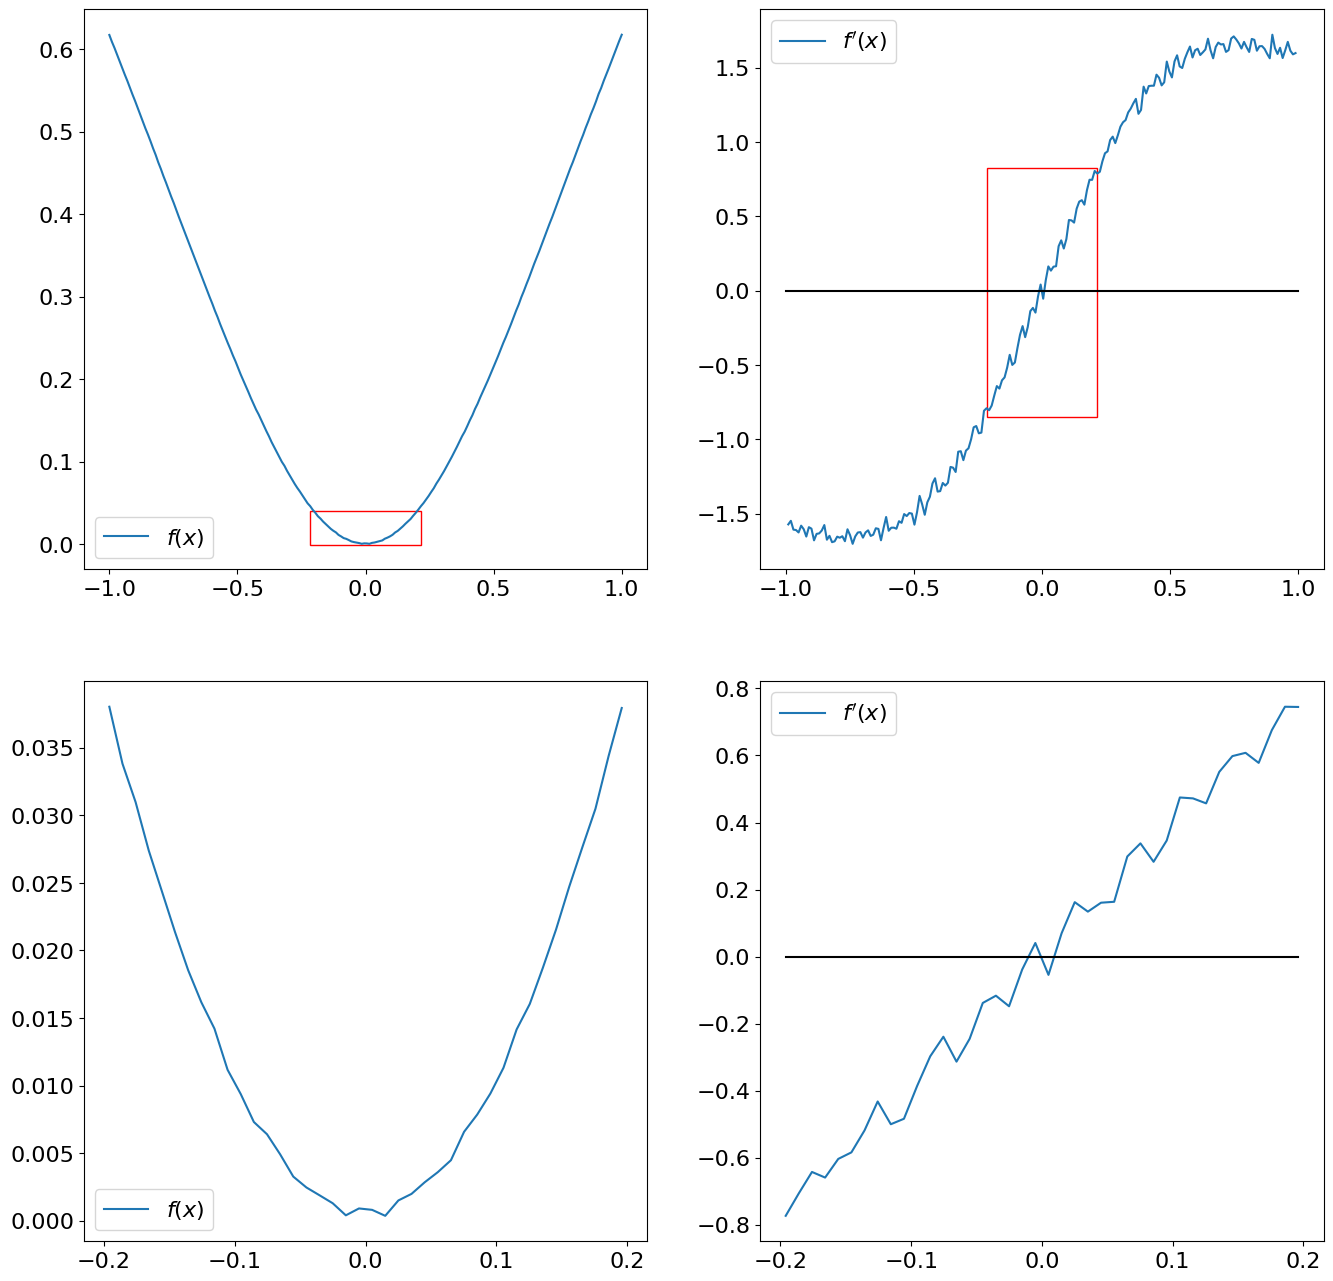

In [4]:
noise_amplitude = 1e-3
N = 200
dx = 2/N
xzoom = 0.2

def f(x):
    return np.arctan(x)**2

fig, ax = plt.subplots(2,2, figsize=(16,16))

x = np.linspace(-1, 1, N)
f_num = f(x)
np.random.seed(2)  # set the seed to ensure we always get the same "random" noise
f_num += np.random.rand(N) * noise_amplitude
# numerical derivative using central differencing: f_i = (f_{i+1}-f_{i-1})/dx
# this computes the derivative for the points x[1:-1]
df_num = (f_num[2:]-f_num[:-2])/dx

# x, f and df restricted to a zoom-in -0.2\lt x\lt 0.2
cond = (x > -0.2) & (x < 0.2)
xz = x[cond]
fz = f_num[cond]
dfz = df_num[cond[1:-1]]

ax[0,0].plot(x, f_num, label='$f(x)$')
ax[0,0].legend()

ax[1,0].plot(xz, fz, label='$f(x)$')
ax[1,0].legend()
from matplotlib.patches import Rectangle
axis = ax[1,0].axis()
p = Rectangle([axis[0], axis[2]], width=axis[1]-axis[0], height=axis[3]-axis[2],
              edgecolor='red', fill=False)
ax[0,0].add_artist(p)


ax[0,1].plot(x[1:-1], df_num, label="$f'(x)$")
ax[0,1].legend()
ax[0,1].plot([x[0], x[-1]], [0, 0], 'k')  # x-axis

ax[1,1].plot(xz, dfz, label="$f'(x)$")
ax[1,1].plot([xz[0], xz[-1]], [0, 0], 'k')  # x-axis
ax[1,1].legend()
from matplotlib.patches import Rectangle
axis = ax[1,1].axis()
p = Rectangle([axis[0], axis[2]], width=axis[1]-axis[0], height=axis[3]-axis[2],
              edgecolor='red', fill=False)
ax[0,1].add_artist(p);

In the figure above, we see a quadratic function $f$ with some added noise. The noise here is purely random, but this is very similar to noise one might see in the output of a numerical model, or in measurements. In the top-left figure the noise is hardly visible, and only in the zoom-in of the same graph (bottom-left figure) some noise can be seen. When we look at the derivative of $f$ treated as a piecewise linear function (top-right, and zoom-in bottom-right), we see a lot more noise. This is typical of numerical derivatives on gridded data; Even if the noise in $f$ itself is small, the noise in $f'$ is significant because the variations happen over small distances at the scale of the grid resolution. An optimisation algorithm that finds local minima by searching for the roots in $f'$ will strugle to reduce the absolute value of $f'$ to below $0.1$.

# Truncated Newton Methods
So far in the linear solve to compute the next Newton step:

$$
  \underline{\mathbf B}^{(i)} {\bf p}^{(i)} = -{\bf F}({\bf x}^{(i)}),
$$

where $\underline{\mathbf B}^{(i)}$ is the Hessian, or an approximation of it, at ${\bf x}^{(i)}$, we have used a direct solve to compute ${\bf p}^{(i)}$ exactly. In many cases, as we have seen in lecture 4, iterative solvers can be more efficient than direct methods.

In lecture 3, we have already encountered a very effective iterative solver, the Conjugate Gradient method, to solve linear systems where the matrix is SPD. We know that after $n$ iterations (where $n$ is the number of rows/columns of the matrix) this method converges to the answer exactly. A natural idea would be to look if we can get away with solving the system less accurately, and stop the iteration as soon as the residual ${\bf r}={\bf A}{\bf x}-{\bf b}$ has been reduced by a certain factor (a relative tolerance!). After all we have seen that we can get away with pretty big approximations in the Hessian itself.

As it turns out, we can indeed get away with a very loose tolerance, and thus dramatically decrease the cost of the linear solve in each Newton iteration. Moreover, it turns out that making this approximation can actually increase the robustness of the Newton method! This seems like a little counter-intuitive, but is in-line with our experience with trust region methods and also a method like BFGS. There the modification/approximation of the Hessian makes the method more robust when the exact Hessian is not well-behaved (i.e. not SPD). A similar process takes place if we solve the update-step not exactly.

As a reminder, when we were looking at the Conjugate Gradient algorithm, it became clear that the very first iteration is exactly the same as steepest descent. Thus intuitively we can see that a rough approximation with just a few iterations of CG stays closer to the steepest descent method, which deals more robustly with an indefinite Hessian. What is remarkable however, that it can be proven that this rough approximation is enough to maintain the convergence properties of the Newton method when we are getting near the local minimum. In other words we only need to do a little better than steepest descent, to maintain the local convergence properties of the Newton method.

This approach, Newton's method where the linear solve is done with only a few iterations of an iterative solver, is refered to as a <a class="definition" href="#definitions" id="truncatedNewton">truncated Newton</a> method. In particular the combination of Newton with truncated CG, often just referred to simply as <a class="definition" href="#definitions" id="NewtonCG">Newton-CG</a>, is a very popular method. Where, as we have seen yesterday, pure Newton with a line search is not very robust in the present of indefinite Hessians, Newton-CG with a line search is a much more robust method (as we will see in the example below). In `scipy.optimization` it is available as `newton-cg` and the `tnc` methods of [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) (the latter also offers simple bound restrictions as L-BFGS-B). For added robustness the Newton-CG approach is also often combined with a trust region approach (e.g. `trust-ncg` of [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

## Truncated Newton-CG Example
We return to the example in lecture notes 5, where we were trying to find the minimum of

$$
  f(x, y) = \frac{\left(x^2 + (\gamma y)^2 -1\right)^2}{x^2 + (\gamma y)^2 - 1/h} - y,
$$

and we found Newton's method to be struggling even with a line search. First let's repeat the definition of the function in code, and its first and second derivative:

In [5]:
from mpl_toolkits.mplot3d import Axes3D

gamma = 5  # aspect ratio
mx = 2.5  # width of axis view
x0 = np.array([-0.5,-0.5])  # initial guess
h = 10.  # height of bump

# here and below we ... (three dots) to leave free any unspecified dimensions
# so if x.shape=(D,):    x[...,0] = x[0]
#    if x.shape=(N,D):   x[...,0] = x[:,0]
#    if x.shape=(M,N,D): x[...,0] = x[:,:,0], etc.
# in this way the function f works regardless of whether we give it one point in R^D
# or a MxN raster of points
def f(x):
    return (x[...,0]**2 + (gamma*x[...,1])**2 - 1)**2/(x[...,0]**2 + (gamma*x[...,1])**2 + 1/h) - x[...,1]


def dfdx(xy):
    x = xy[...,0]
    y = xy[...,1]
    ans = np.empty_like(xy)
    ans[...,0] = -2*x*(gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h)**2 + 4*x*(gamma**2*y**2 + x**2 - 1)/(gamma**2*y**2 + x**2 + 1/h)
    ans[...,1] = -2*gamma**2*y*(gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h)**2 + 4*gamma**2*y*(gamma**2*y**2 + x**2 - 1)/(gamma**2*y**2 + x**2 + 1/h) - 1
    return ans


def hess(xy):
    x = xy[...,0]
    y = xy[...,1]
    ans = np.empty(xy.shape+(xy.shape[-1],))
    ans[...,0,0] = 2*(2*gamma**2*y**2 + 4*x**2*(gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h)**2 - 8*x**2*(gamma**2*y**2 + x**2 - 1)/(gamma**2*y**2 + x**2 + 1/h) + 6*x**2 - (gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h) - 2)/(gamma**2*y**2 + x**2 + 1/h)
    ans[...,0,1] = 8*gamma**2*x*y*((gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h)**2 - 2*(gamma**2*y**2 + x**2 - 1)/(gamma**2*y**2 + x**2 + 1/h) + 1)/(gamma**2*y**2 + x**2 + 1/h)
    ans[...,1,0] = ans[...,0,1]
    ans[...,1,1] = 2*gamma**2*(4*gamma**2*y**2*(gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h)**2 - 8*gamma**2*y**2*(gamma**2*y**2 + x**2 - 1)/(gamma**2*y**2 + x**2 + 1/h) + 6*gamma**2*y**2 + 2*x**2 - (gamma**2*y**2 + x**2 - 1)**2/(gamma**2*y**2 + x**2 + 1/h) - 2)/(gamma**2*y**2 + x**2 + 1/h)
    return ans

To implement the Newton-CG method we copy the `conjugate_gradient` routine from lecture 3. We have made two modifications however:
1. we implement a relative tolerance stopping criterion, which stops the iteration as soon as the residual norm is smaller than a specified fraction `rtol` of the the initial residual.
2. we know that the conjugate gradient method only works for SPD matrices. We can detect indefiniteness if the inner product $\langle {\bf p},\underline{\mathbf A}{\bf p}\rangle$ becomes 0 or negative. Rather than continuing at that point, we now indicate failure by returning `None`

In [6]:
def conjugate_gradient(A, b, x0, rtol=1e-5, verbose=False):
    r0 = b - A @ x0
    init_residual_norm = sl.norm(r0)
    p = r0
    x = x0
    i = 0
    while sl.norm(r0)>rtol*init_residual_norm:
        Ap = A @ p
        pAp = np.dot(p, Ap)
        if pAp <= 0.0:
            # A is not SPD: failure
            if verbose:
                print('CG Failure after {} iterations'.format(i))
            return None
        alpha = np.dot(r0, r0) / pAp
        x = x + alpha * p
        r1 = r0 - alpha * Ap
        beta = np.dot(r1, r1)/np.dot(r0, r0)
        p = r1 + beta * p
        r0 = r1
        i = i + 1
    if verbose:
        print('CG Converged after {} iterations'.format(i))
    return x

Then we copy the `simple_line_search` from yesterday's notes and define `newton_cg_method` which is the same `newton_method_ls` except that the direct solve `sl.solve` has been replaced with a call to `conjugate_gradient`. When the CG method fails (due to the Hessian not being SPD), we switch to steepest descent instead.

In [7]:
def simple_line_search(x, p, f, initial_slope, alpha=1e-4, max_search_iter=100):
    """Simple line search that halves lambda until the Armijo rule is satisfied
    
    x - initial point (at lambda=0)
    p - search direction, search is along x+lambda*p
    f - (callback) function to minimize
    initial_slope - derivative of f in x in p-direction"""
    lamda = 1.
    if initial_slope==0.0:
        return x, 1.0, 0
    for j in range(max_search_iter):
        xt = x + lamda*p
        # check Armijo rule:
        if f(xt) - f(x) <= alpha*lamda*initial_slope:
            break
        # uncomment to follow convergence of line search:
        # print(j,lamda,f(xt)-f(x), alpha*lamda*initial_slope)
        lamda /= 2.
    else:
        raise Exception("Line search did not converge")
    return xt, lamda, j

def newton_cg_method(F, jac, f, line_search, x_0, atol = 1.e-5, maxiter=100, verbose=False, cg_rtol=0.5):
    "Newton-CG method with line search"
    x_n = []
    y_n = []
    x = x_0
    
    # iterate until we hit break either as we hit tolerance or maximum number iterations
    # since we include the initial guess, the max. number of entries is maxiter+1
    for i in range(maxiter+1):
        x_n.append(x)
        Fx = F(x)
        y_n.append(Fx)
        
        # Newton update:
        p = conjugate_gradient(jac(x), -Fx, np.zeros(len(x)), rtol=cg_rtol, verbose=verbose)
        if p is None:
            # CG has failed (due to an indefinite matrix)
            # let's do steepest descent instead
            p = -Fx
                
        x, lamda, reductions = line_search(x, p, f, np.dot(F(x), p))
        if verbose:
            print("In iteration {}, x={}; {} reductions were needed (lambda={})".format(i, x_n[-1], reductions, lamda))
        if sl.norm(F(x))<atol:
            break
    else:
        print("Newton Convergence not achieved - stopped with maximum n/o iterations")
    
    return x_n, y_n

The tolerance used in CG, can be specified via the `cg_rtol` argument to `newton_cg_method`. Let us first see what its behaviour is if we specify a tight tolerance:

In [8]:
x0 = np.array([-0.5, -0.5])
x_n, y_n = newton_cg_method(dfdx, hess, f, simple_line_search, x0, cg_rtol=1e-7, atol=1.e-5, verbose=True)

CG Converged after 2 iterations
In iteration 0, x=[-0.5 -0.5]; 1 reductions were needed (lambda=0.5)
CG Converged after 2 iterations
In iteration 1, x=[-0.27629238 -0.26600667]; 0 reductions were needed (lambda=1.0)
CG Failure after 1 iterations
In iteration 2, x=[-0.19578792 -0.15909856]; 7 reductions were needed (lambda=0.0078125)
CG Converged after 2 iterations
In iteration 3, x=[-0.19895349 -0.2155953 ]; 0 reductions were needed (lambda=1.0)
CG Failure after 1 iterations
In iteration 4, x=[-0.23584547 -0.18559423]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 5, x=[-0.23647361 -0.19013919]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 6, x=[-0.23675966 -0.18807684]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 7, x=[-0.23719582 -0.18892624]; 6 reductions were needed (lambda=0.015625)
CG Failure after 1 iterations
In iteration 8, x=[-0.23794046 -0.18812888]; 

This does not seem to work very well. It stopped because we hit the maximum number of iterations. And indeed if we check the derivative in the last point:

In [9]:
print(dfdx(x_n[-1]))

[0.08322388 0.22110383]


we see we haven't reached a stationary point. There is an improvement of `newton_method_ls` from yesterday, in that the method at least does not stall (unlike `newton_method_ls` which gets stuck as soon as it hits a indefinite Hessian). If we increase the `maxiter` argument we can in fact get convergence:

In [10]:
x0 = np.array([-0.5, -0.5])
x_n, y_n = newton_cg_method(dfdx, hess, f, simple_line_search, x0, 
                            cg_rtol=1e-7, atol=1.e-5, maxiter=1000,
                            verbose=True)
print('Number of iterations:', len(x_n))
print('Final point x = {}', x_n[-1])
print('with derivative ', dfdx(x_n[-1]))

CG Converged after 2 iterations
In iteration 0, x=[-0.5 -0.5]; 1 reductions were needed (lambda=0.5)
CG Converged after 2 iterations
In iteration 1, x=[-0.27629238 -0.26600667]; 0 reductions were needed (lambda=1.0)
CG Failure after 1 iterations
In iteration 2, x=[-0.19578792 -0.15909856]; 7 reductions were needed (lambda=0.0078125)
CG Converged after 2 iterations
In iteration 3, x=[-0.19895349 -0.2155953 ]; 0 reductions were needed (lambda=1.0)
CG Failure after 1 iterations
In iteration 4, x=[-0.23584547 -0.18559423]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 5, x=[-0.23647361 -0.19013919]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 6, x=[-0.23675966 -0.18807684]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 7, x=[-0.23719582 -0.18892624]; 6 reductions were needed (lambda=0.015625)
CG Failure after 1 iterations
In iteration 8, x=[-0.23794046 -0.18812888]; 

In iteration 186, x=[-0.41162115 -0.17556415]; 5 reductions were needed (lambda=0.03125)
CG Failure after 1 iterations
In iteration 187, x=[-0.41467513 -0.17687866]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 188, x=[-0.41525159 -0.1752134 ]; 5 reductions were needed (lambda=0.03125)
CG Failure after 1 iterations
In iteration 189, x=[-0.41833664 -0.17650642]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 190, x=[-0.41892142 -0.17486221]; 5 reductions were needed (lambda=0.03125)
CG Failure after 1 iterations
In iteration 191, x=[-0.42203442 -0.17609722]; 6 reductions were needed (lambda=0.015625)
CG Failure after 1 iterations
In iteration 192, x=[-0.42322795 -0.17292241]; 7 reductions were needed (lambda=0.0078125)
CG Failure after 1 iterations
In iteration 193, x=[-0.42420625 -0.17510284]; 5 reductions were needed (lambda=0.03125)
CG Failure after 1 iterations
In iteration 194, x=[-0.42698771 -0.17255

The performance, needing 211 iterations, is not very good however, as it seems to switch to steepest descent nearly everywhere. Now let's see what happens if we radically increase `cg_rtol` to 0.5:

In [11]:
x0 = np.array([-0.5, -0.5])
x_n, y_n = newton_cg_method(dfdx, hess, f, simple_line_search, x0, 
                            cg_rtol=0.5, atol=1.e-5, maxiter=1000,
                            verbose=True)
print('Number of iterations:', len(x_n))
print('Final point x = {}', x_n[-1])
print('with derivative ', dfdx(x_n[-1]))

CG Converged after 1 iterations
In iteration 0, x=[-0.5 -0.5]; 0 reductions were needed (lambda=1.0)
CG Failure after 0 iterations
In iteration 1, x=[-0.48193288 -0.02973859]; 6 reductions were needed (lambda=0.015625)
CG Converged after 1 iterations
In iteration 2, x=[-0.61198696 -0.21474448]; 0 reductions were needed (lambda=1.0)
CG Converged after 1 iterations
In iteration 3, x=[-0.60479754 -0.14086096]; 0 reductions were needed (lambda=1.0)
CG Failure after 0 iterations
In iteration 4, x=[-0.60784554 -0.15042588]; 0 reductions were needed (lambda=1.0)
CG Failure after 1 iterations
In iteration 5, x=[-0.764872   -0.12192447]; 1 reductions were needed (lambda=0.5)
CG Converged after 2 iterations
In iteration 6, x=[-0.82888932  0.12295839]; 1 reductions were needed (lambda=0.5)
CG Converged after 1 iterations
In iteration 7, x=[-0.60217426  0.1814797 ]; 0 reductions were needed (lambda=1.0)
CG Converged after 2 iterations
In iteration 8, x=[-0.59916454  0.16811659]; 1 reductions were 

As predicted truncated Newton-CG converges much faster. It manages to stear 
away from regions with a problematic Hessian, and only fails the CG a few times.

# Computing and Testing the Gradient: Taylor Test

## Obtaining Gradient Information

As we have seen so far, using gradient information can significantly improve convergence of optimisation algorithms. When using quasi-Newton methods for optimisation we can avoid the need for a Hessian, but we still require the gradient of the function we optimise. Calculating the gradient however can be a challenge. Often the evaluation of the function $f$ itself involves running a, potentially complex, computer code.
This means that we need to work out what the derivative is of the outcomes of our computer model with respect to the things we want to vary in the optimisation. There are various ways of obtaining this information. For small codes, we can work it out for ourselves by looking at the actual mathematical operations that are performed in sequence within a (computer) function and applying the chain rule to it. You will find out that this approach gets a little tedious soon, and will be infeasible for larger codes.

There are automated ways to derive this information using so called <a class="definition" href="#definitions" id="AutomatedDifferentationAD">Automated Differentation (AD)</a> tools. For compiled languages they may scan and interpret the actual source code and automatically derive new code that computes the derivative. Another approach is to record *at run-time* which operations are being performed, and then, when requested, to use this information to derive the gradient. There are various different approaches implemented in a number of Automated Differenation frameworks each with their own strengths and weaknesses: the level of complexity, how much manual intervention is still required, and run-time efficiency.

If the function evaluation is based upon the solution of a PDE, with the input parameters used as initial or boundary conditions, or source terms, we may also consider the adjoint method. Here we reformulate the optimisation problem as a PDE-constrained optimisation problem and derive associated adjoint equations, a new PDE that we need to solve to obtain the desired gradient information. We will come back to this topic in lecture 11.

## Taylor Test
Regardless of the method that is used to construct the derivative, it will become clear that this can be an error-prone business. It is therefore of the greatest importance to *test* whether our derivative function is correct. The best way to do this, is to use the so called <a class="definition" href="#definitions" id="Taylortest">Taylor test</a>. The idea is very simple: let's treat our computer program as a mathematical function $f({\bf x})$ that takes a number of input values gathered together in a vector ${\bf x}$ and returns a value $f({\bf x})$. Of course our program could be producing a lot of numbers, but for simplicity let's say there is just one output, the number $f({\bf x})$. Then if $f'({\bf x})$ is the derivative of this function - this implies that $f$ is actually differentiable as a mathematical function - then by Taylor's theorem we may write:

$$
  f({\bf x} + {\bf h}) = f({\bf x}) + f'({\bf x})\cdot{\bf h} + \mathcal{O(\|h\|^2)}\;\;
  \text{ for }\|{\bf h}\|\to 0
$$

where ${\bf h}$ is a (small) perturbation of our input values ${\bf x}$. Note that if the computer program has $n$ input values, then both ${\bf x}$ and ${\bf h}$ are vectors in $\mathbb{R}^n$, and we need to consider perturbations in all $n$ directions.

Another way of phrasing the Taylor approximation, is to say that $f$ and its linear approximation around $f$ converge quadratically as $\|h\|\to 0$. The difference between the two is called the Taylor residual

$$
  r({\bf h}) = f({\bf x} + {\bf h}) - f({\bf x}) - f'({\bf x})\cdot{\bf h}
$$

So if we have correctly written (or automatically derived) a computer function that computes the derivative $f'({\bf x})$, and we use this to compute the Taylor residual, we should have

$$
  |r({\bf h})| \leq C\|{\bf h}\|^2\;\;\text{ for small enough }{\bf h}
$$

One problem with these sorts of tests is that we don't necessarily know what a small enough ${\bf h}$ is before the assymptotic behaviour becomes clear. A way to proceed is to consider a series of 

$$
  \newcommand\fac{\mathcal{F}}
  {\bf h}_k= \frac{{\bf h}_0}{\fac^k},
$$

where we divide $h_k$ by a factor of $\fac$ (usually $\fac=2$) each time. It is then possible to show that

$$
  \lim_{k\to\infty} \frac{r({\bf h}_k)}{r({\bf h}_{k+1})} \geq \fac^2
$$

It is convenient to take the $\log$ of this series and we get

$$
  \lim_{k\to\infty} \frac{\log\left(\frac{r({\bf h}_k)}{r({\bf h}_{k+1})}\right)}{\log(\fac)} \geq 2
$$

In many cases this series will in fact converge exactly to 2, but for instance if the second derivative is zero the limit may be higher. Often when $h_k$ is not yet small enough the term on the left starts out being smaller than two, and so our test should keep dividing by a factor of $\fac$ until it reaches 2. We typically allow for some round off error and allow a value close to 2.

# Example: Shape Optimisation <a class="tocSkip"></a>

## Polygons, Perimeter and Area
To bring some of the ideas of today's lecture in to practice we will look at a shape optimisation problem based on the geometric properties of a shape such as the perimeter and area. We will describe the shapes as polygons. Polygons are given by a list of points, the vertices, with edges that are straight lines between the subsequent vertices. There are other, more sophisticated ways to describe shapes, such as [Bézier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve), but we will not use those here. We use the convention that the first and the last point in the list are the same, to describe a closed polygon. Another convention we use is that the vertices in this list are given in counter clockwise order.

To start we introduce a little helper function that creates a regular polygon, a polygon of which all edge lengths and all angles are the same.

In [12]:
def regular_polygon(R, n):
    """Create a regular polygon of radius R with n sides"""
    alpha = 2*np.pi/n
    x = []
    for i in range(n+1):
        x.append([R*np.cos(alpha*i), R*np.sin(alpha*i)])
    return np.array(x)        

Note that here, and elsewhere we use $n$ as the number of sides of the polygon. The number of vertices, including the last vertex which is at the same location as the first, is $n+1$. Plotting is straightforward:

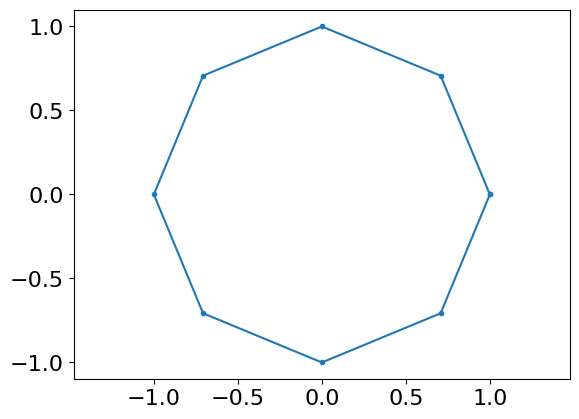

In [13]:
x = regular_polygon(1, 8)
plt.plot(x[:,0], x[:,1], '.-')
plt.axis('equal');

Next we define two functions computing the area and perimeter of an abritrary polygon. The perimeter is actually given by a function called `length` as the perimeter of a polygon is just the sum of the length of the edges.

In [14]:
def area(x):
    """Compute the area of the polygon x"""
    n = len(x)-1
    a = 0.
    for i in range(n):
        a += (x[i,0]-x[i+1,0])*(x[i,1]+x[i+1,1])/2.
    return a

def length(x):
    """Compute the length of the path described by the list of points x."""
    n = len(x)-1
    l = 0.
    for i in range(n):
        l += sl.norm(x[i+1]-x[i])
    return l

As always, we should test all components of our software. In the today's tutorial you will be asked to verify the results of these function applied to some regular polygons using known analytical expressions for these.

Since we want to use these function in an gradient-based optimisation, we also need derivatives of these functions, and as argued in previous section test these using the Taylor test. We start by looking at the derivative of our `length` function. The function `length`$({\bf x})$ takes a vector ${\bf x}\in\mathbb{R}^{(n+1)\times 2}$, where $n$ is the number of edges, $n+1$ the number of vertices, and we need a $\times 2$ because we are in 2D and each vertex is given by a 2-vector. Therefore the derivative of `length` in ${\bf x}$ should itself be a vector in $\mathbb{R}^{(n+1)\times 2}$, which indicates how much the function `length`$({\bf x})$ would change by a small perturbation in each direction. Strictly speaking we should actually be talking about ${\bf x}$ and the derivative as vectors in $\mathbb{R}^{2(n+1)}$ (for example with $n=4$, they would be vectors in $\mathbb{R}^{10}$), but for convenience in our code we store them as rank 2 arrays with a shape of $(n+1,2)$, so $n+1$ rows and 2 columns.

We claim that this derivative is computed by the following function:

In [15]:
def grad_length(x):
    """Compute the gradient of length(x)."""
    n = len(x)-1
    dldx = np.zeros((n+1, 2))
    for i in range(n):
        dldx[i, 0] += -(x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
        dldx[i+1, 0] += (x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
        dldx[i, 1] += -(x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
        dldx[i+1, 1] += (x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
    return dldx

Compare this function with the original `length` function and make sure you understand why this would give us the derivative. First let's write out `length` as a mathematical formula:

$$
  l({\bf x}) = \sum l_i({\bf x}) = \sum_i \|{\bf x}_{i+1}-{\bf x}_i\|,
$$

where $l_i$ are the lengths of the individual edges $l_i$.
Then the gradient of the entire length can be written as the sum of gradients of the individual edge lengths:

$$
  \frac{\partial l({\bf x})}{\partial {\bf x}}
  = \sum_i \frac{\partial l_i({\bf x})}{\partial {\bf x}}
  = \sum_i \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial {\bf x}}
$$

Each edge length $l_i$ can be worked out further as

$$
  l_i({\bf x}) = \|{\bf x}_{i+1}-{\bf x}_i\| = \sqrt{\left(x_{i+1,0}-x_{i,0}\right)^2
     + \left(x_{i+1,1}-x_{i,1}\right)^2}
$$

as a function of the 4 coefficients $x_{i,0}, x_{i,1}, x_{i+1,0}$, and $x_{i+1,1}$, the "$x$ and $y$" coordinates of positions ${\bf x}_{i}$ and ${\bf x}_{i+1}$. 

The derivative of each individual $l_i$ with respect to all polygon positions ${\bf x}$, is a large $(n+1)\times 2$ vector that is mostly zero, except for the 4 entries associated these coefficients:

\begin{align*}
  \frac{\partial l_i({\bf x})}{\partial {\bf x}} =
  \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial {\bf x}} &= 
  \begin{pmatrix}
    0 & \dots &
    \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial x_{i,0}} &
    \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial x_{i,1}} &
    \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial x_{i+1,0}} &
    \frac{\partial\|{\bf x}_{i+1}-{\bf x}_i\|}{\partial x_{i+1,1}} &
\dots & 0 
  \end{pmatrix} \\
  &= 
    \begin{pmatrix}
    0 & \dots &
    -\frac{x_{i+1,0}-x_{i,0}}{\|{\bf x}_{i+1}-{\bf x}_i\|} &
    \frac{x_{i+1,0}-x_{i,0}}{\|{\bf x}_{i+1}-{\bf x}_i\|} &
    -\frac{x_{i+1,1}-x_{i,1}}{\|{\bf x}_{i+1}-{\bf x}_i\|} &
    \frac{x_{i+1,1}-x_{i,1}}{\|{\bf x}_{i+1}-{\bf x}_i\|} &
\dots & 0 
  \end{pmatrix}
\end{align*}

In code this looks like:
```python
dlidx = np.zeros((n+1, 2))
dlidx[i, 0] = -(x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
dlidx[i+1, 0] = (x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
dlidx[i, 1] = -(x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
dlidx[i+1, 1] = (x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
```

That's already nearly the same as the function `grad_length`. The only last step is to simply add up all the derivatives of all the individual edge lengths. This is done in `grad_length` by starting a single `dldx`, for the derivate of the total length, and simply adding up the individual edge length derivatives as we loop through $i$. Note the use of `+=` in the `length` function above:
```dldx[i, 0] += C``` is short for ```dldx[i, 0] = dldx[i,0] + C```.

OK, let's now test this `grad_length` function and verify that it is indeed the correct derivative of `length` using the Taylor test we described in the previous section. We provide the following function to perform this test:

In [16]:
def taylor_test(f, grad_f, x, h0, max_iter=8, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    # these two stay the same, so we can compute them outside the loop:
    fx = f(x)
    dfdx = grad_f(x)
    
    for i in range(max_iter):
        if len(h.shape)>1:
            # tensordot sums over all indices of h and corresponding last indices of dfdx
            r = f(x + h) - fx - np.tensordot(dfdx, h, axes=len(h.shape))
        else:
            r = f(x + h) - fx - dfdx @ h
            
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-3, 1e-4), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

All we need to do, is give it is the function and gradient to test (`length` and `grad_length` in this case), a point ${\bf x}$ (a vector representing a polygon) to test the function in, and an initial perturbation:

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.90687861 1.94747315 1.97206217 1.98557668 1.99266907 1.99630391
 1.9981442 ]


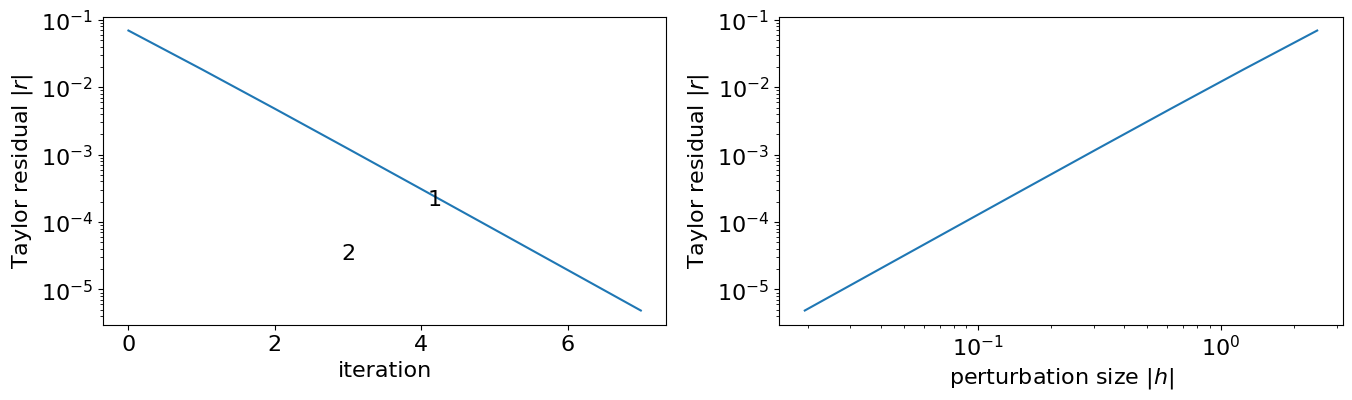

In [17]:
# we test the derivative around a regular polygon
R = 1.5
n = 6
x = regular_polygon(R, n)

# our original perturbation h0 is chosen as a random vector
# with values between 0 and 1
np.random.seed(0)  #  (* see note 2 below)
h0 = np.random.random((n+1, 2))

# NOTE 1: this *not* a small perturbation with respect to
# a regular polygon with R=1.5, but we do this for demonstration
# purposes. Normally you would probably start your test
# with a much smaller perturbation which you expect to be
# much closer to the asymptotic convergence

# NOTE 2: we set a seed here to ensure we get the same
# random vector every time - this is again for demonstration
# purposes only - you do not need to do this

taylor_test(length, grad_length, x, h0)

We observe that the order of convergence, computed from subsequent iterations, rapidly reaches the expected value of 2. In today's tutorial you will be asked to derive and test the gradient of the `area` function as well. We will then perform our first shape optimisation based upon a shape factor functional that combines both functions. This is a first step in a shape optimisation problem that we will further develop next week, where we will optimise the shape of an airfoil.

# List of Definitions
<a id="definitions"/>

* <a class=definition href="#quasiNewtonsecantmethods">quasi-Newton secant methods</a>
* <a class=definition href="#secantequation">secant equation</a>
* <a class=definition href="#Broydensgoodmethod">Broyden's "good" method</a>
* <a class=definition href="#Broydensbadmethod">Broyden's "bad" method</a>
* <a class=definition href="#SymmetricRankOneSRmethod">Symmetric Rank One (SR1) method</a>
* <a class=definition href="#BroydenFletcherGoldfarbShannoBFGSmethod">Broyden-Fletcher-Goldfarb-Shanno (BFGS) method</a>
* <a class=definition href="#limitedmemoryapproach">limited memory approach</a>
* <a class=definition href="#iterativemethods">iterative methods</a>
* <a class=definition href="#stoppingcriterion">stopping criterion</a>
* <a class=definition href="#absolutetolerance">absolute tolerance</a>
* <a class=definition href="#relativetolerance">relative tolerance</a>
* <a class=definition href="#stallingcriteria">stalling criteria</a>
* <a class=definition href="#truncatedNewton">truncated Newton</a>
* <a class=definition href="#NewtonCG">Newton-CG</a>
* <a class=definition href="#AutomatedDifferentationAD">Automated Differentation (AD)</a>
* <a class=definition href="#Taylortest">Taylor test</a>
